<a href="https://colab.research.google.com/github/Mengzhe/FreddieMacMortgageProject/blob/main/step2_create_windowed_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [ ]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

%matplotlib inline

import sklearn
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import (confusion_matrix, 
                             roc_auc_score, 
                             average_precision_score)
from sklearn.model_selection import cross_val_score

from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import joblib
import pickle

# import shap
import warnings
import time
warnings.filterwarnings("ignore")

import json
from collections import defaultdict

from datetime import datetime
import pytz
from datetime import date

# from bayes_opt import BayesianOptimization

# trained_model_folder_path = "/content/drive/MyDrive/Colab Notebooks/Kaggle/LendingClub/trained_models/"

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def extract_windows(array, clearing_time_index, max_time, sub_window_size):
    examples = []
    # start = clearing_time_index + 1 - sub_window_size + 1
    start = clearing_time_index - sub_window_size + 1

    for i in range(max_time+1):
        if start+sub_window_size+i<sub_window_size:
            example = np.zeros((sub_window_size, array.shape[1])) ## zero padding
            example[-(start+sub_window_size+i):] = array[:start+sub_window_size+i]
        else:
            example = array[start+i:start+sub_window_size+i]

        examples.append(np.expand_dims(example, 0))
    
    return np.vstack(examples)

In [ ]:
def shift_yr_qtr(yr_qtr):
    year = int(yr_qtr[:2])
    q = int(yr_qtr[-1])
    q_sum = (year*4+q-1)-1
    year = q_sum//4
    q = q_sum%4+1
    return str(year)+'Q'+str(q)

def shift_yr_mth(yr_mth):
    year = int(yr_mth[:4])
    month = int(yr_mth[4:])
    mth_sum = (year*12+month-1)-1
    year = mth_sum//12
    month = mth_sum%12+1
    if month<10:
        return str(year)+'0'+str(month)
    else:
        return str(year)+str(month)



## Load data

##### Load data: orig, performance

In [ ]:
dir_data = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/'
dir_data_orig = os.path.join(dir_data, 'data_orig_2011_2019_pre_chg_20210803_2235.csv')
dir_data_monthly = os.path.join(dir_data, 'data_monthly_2011_2019_pre_chg_20210803_2235.csv') 

print('dir_data_orig', dir_data_orig)
print('dir_data_monthly', dir_data_monthly)

dir_data_orig /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/data_orig_2011_2019_pre_chg_20210803_2235.csv
dir_data_monthly /content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/data_monthly_2011_2019_pre_chg_20210803_2235.csv


In [ ]:
df_orig = pd.read_csv(dir_data_orig, index_col=0)
df_monthly = pd.read_csv(dir_data_monthly, index_col=0)

print("df_orig.shape", df_orig.shape)
print("df_monthly.shape", df_monthly.shape)

df_orig.shape (20053, 19)
df_monthly.shape (1694602, 10)


In [ ]:
df_orig['o_yr_qtr'] = df_orig['loan_id'].apply(lambda x: x[1:5])
## shift year and quarter since economic factors can have a quarter lag
df_orig['o_yr_qtr'] = df_orig['o_yr_qtr'].apply(shift_yr_qtr) 

df_orig['o_st_yr_qtr'] = df_orig['o_prop_st']+'_'+df_orig['o_yr_qtr']

In [ ]:
df_orig.head()

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr
6,F11Q10001082,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4
7,F11Q10001104,201103,360,224000,0.0,80,4.375,R,N,0,710,unknown,33,1,1,P,OR,SF,9,10Q4,OR_10Q4
9,F11Q10001291,201103,360,165000,30.0,95,4.375,R,N,0,739,unknown,29,2,1,P,NC,SF,9,10Q4,NC_10Q4
11,F11Q10001944,201103,360,144000,0.0,72,4.625,R,C,0,769,unknown,23,2,1,P,IL,SF,9,10Q4,IL_10Q4
12,F11Q10002098,201103,360,142000,0.0,77,4.625,R,N,0,784,unknown,20,2,1,P,NE,SF,9,10Q4,NE_10Q4


In [ ]:
df_orig['o_yr_qtr_shifted'] = df_orig['o_yr_qtr'].apply(shift_yr_qtr)
df_orig.sample(100).head()

,loan_id,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted
51357,F13Q30055065,201309,360,319000,0.0,63,4.250,R,P,0,696,N,26,2,1,P,CO,PU,9,13Q2,CO_13Q2,13Q1
47158,F13Q20255027,201307,360,405000,0.0,58,3.375,B,N,0,771,unknown,32,2,1,P,CA,SF,9,13Q1,CA_13Q1,12Q4
72096,F17Q30130700,201710,360,200000,0.0,49,3.875,R,P,0,763,N,25,2,1,P,IL,SF,3,17Q2,IL_17Q2,17Q1
63426,F14Q40174684,201501,360,88000,0.0,80,3.950,R,P,0,758,Y,21,1,1,P,OH,SF,9,14Q3,OH_14Q3,14Q2
21828,F12Q20149394,201207,360,417000,0.0,77,4.500,R,N,0,731,unknown,25,2,1,P,AL,SF,9,12Q1,AL_12Q1,11Q4


In [ ]:
us_states = set(sorted(df_orig['o_prop_st'].unique().tolist()))

In [ ]:
## merge
df_combined = pd.merge(df_monthly, df_orig, on='loan_id')
df_combined.sort_values(by=['loan_id', 'loan_age'], inplace=True)

df_combined['rep_period'] = df_combined['rep_period'].astype(str)
## shift rep_period 
df_combined['shifted_rep_period'] = df_combined['rep_period'].apply(shift_yr_mth)

## all date-related information are shifted by one month
## so that the lags of economic factors are considered, i.e., one-month or one-quarter lag
df_combined['o_rep_period'] = df_combined.groupby('loan_id').transform('first')['shifted_rep_period']
df_combined['o_st_rep_period'] = df_combined['o_prop_st']+'_'+df_combined['o_rep_period'].astype(str)

df_combined['st_rep_period'] = df_combined['o_prop_st']+'_'+df_combined['shifted_rep_period'].astype(str)
df_combined['rep_yr_qtr'] = df_combined['rep_period'].astype(str).apply(lambda x: x[2:4]+'Q'+str(((int(x[-2:])-1)//3)+1))
df_combined['rep_yr_qtr'] = df_combined['rep_yr_qtr'].apply(shift_yr_qtr)
df_combined['st_rep_yr_qtr'] = df_combined['o_prop_st'] + '_' + df_combined['rep_yr_qtr']

df_combined.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4
2,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1
3,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1
4,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1


##### Load data: house price index 

In [ ]:
dir_hpi = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/house_index_history/HPI_PO_state.xls'
df_hpi = pd.read_excel(dir_hpi)
df_hpi['st_rep_yr_qtr'] = df_hpi['state']+'_'+df_hpi['yr'].apply(lambda x: str(x)[-2:])+'Q'+df_hpi['qtr'].apply(lambda x: str(x))
df_hpi.drop(columns=['Warning', 'index_nsa'], inplace=True)
df_hpi.rename(columns={'index_sa': 'hpi'}, inplace=True)
df_hpi.reset_index(inplace=True, drop=True)
df_hpi.sort_values(by=['state', 'yr', 'qtr'], inplace=True)
df_hpi.drop(columns=['state', 'yr', 'qtr'], inplace=True)

df_hpi

,hpi,st_rep_yr_qtr
0,100.00,AK_91Q1
1,100.41,AK_91Q2
2,101.33,AK_91Q3
3,102.35,AK_91Q4
4,102.68,AK_92Q1
...,...,...
6166,376.17,WY_20Q1
6167,374.26,WY_20Q2
6168,383.05,WY_20Q3
6169,395.14,WY_20Q4


##### Load data: unemployment rate history

In [ ]:
startyears = [2000, 2010, 2020]
endyears = [2009, 2019, 2021]
# dir_ue = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2011_2020.csv'
df_ue_list = []
for startyear, endyear in zip(startyears, endyears):
    dir_ue = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_{startyear}_{endyear}.csv'.format(startyear=startyear, 
                                                                                                                                                    endyear=endyear)
    print(dir_ue)
    df_ue = pd.read_csv(dir_ue)
    df_ue_list.append(df_ue)

df_ue = pd.concat(df_ue_list, ignore_index=True)  
df_ue.drop(columns=['series_id', 'year', 'month', 'st', 'rep_period'], inplace=True)
df_ue.head()


/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2000_2009.csv
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2010_2019.csv
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/monthly_state_ue_rate_2020_2021.csv


,ue_rate,st_rep_period
0,11.1,AL_200912
1,11.0,AL_200911
2,10.9,AL_200910
3,10.8,AL_200909
4,10.6,AL_200908


##### Load data: Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets
https://fred.stlouisfed.org/series/CORSFRMT100N

,charge_off_rate,rep_yr_qtr
0,0.17,91Q1
1,0.13,91Q2
2,0.16,91Q3
3,0.15,91Q4
4,0.21,92Q1


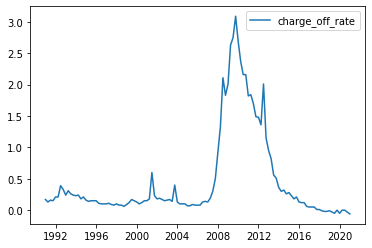

In [ ]:
dir_chgoff = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets.xlsx'
df_chgoff = pd.read_excel(dir_chgoff)
df_chgoff['observation_date'] = pd.to_datetime(df_chgoff['observation_date'])
df_chgoff['rep_yr_qtr'] = df_chgoff['observation_date'].apply(lambda x: str(x.year)[-2:])+'Q'+df_chgoff['observation_date'].apply(lambda x: str(x.quarter))
df_chgoff.rename(columns={'CORSFRMT100S': 'charge_off_rate'}, inplace=True)
plt.plot(df_chgoff['observation_date'], df_chgoff['charge_off_rate'], label='charge_off_rate')
plt.legend()

df_chgoff.drop(columns=['observation_date'], inplace=True)
df_chgoff.head()


##### Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks
https://fred.stlouisfed.org/series/DRSFRMACBS

,dlq_rate,rep_yr_qtr
0,3.10,91Q1
1,3.17,91Q2
2,3.23,91Q3
3,3.29,91Q4
4,3.13,92Q1


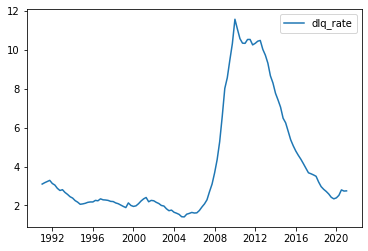

In [ ]:
dir_dlq = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks.xlsx'
df_dlq = pd.read_excel(dir_dlq)
df_dlq['observation_date'] = pd.to_datetime(df_dlq['observation_date'])
df_dlq['rep_yr_qtr'] = df_dlq['observation_date'].apply(lambda x: str(x.year)[-2:])+'Q'+df_dlq['observation_date'].apply(lambda x: str(x.quarter))
df_dlq.rename(columns={'DRSFRMACBS': 'dlq_rate'}, inplace=True)
plt.plot(df_dlq['observation_date'], df_dlq['dlq_rate'], label='dlq_rate')
plt.legend()

df_dlq.drop(columns=['observation_date'], inplace=True)
df_dlq.head()


##### 30-Year Fixed Rate Mortgage Average in the United States
https://fred.stlouisfed.org/series/MORTGAGE30US

,avg_frm,rep_period
0,7.29,197104
1,7.46,197105
2,7.54,197106
3,7.69,197107
4,7.69,197108


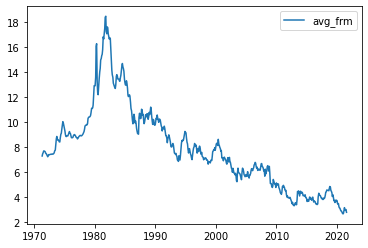

In [ ]:
dir_mort_rate = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/30-Year Fixed Rate Mortgage Average in the United States.xlsx'
df_mort_rate = pd.read_excel(dir_mort_rate)
df_mort_rate['observation_date'] = pd.to_datetime(df_mort_rate['observation_date'])
df_mort_rate.sort_values(by='observation_date', inplace=True)
df_mort_rate['rep_period'] = df_mort_rate['observation_date'].dt.year.astype(str)+df_mort_rate['observation_date'].apply(lambda x: '0'+str(x.month) if x.month<10 else str(x.month))
df_mort_rate = df_mort_rate.groupby('rep_period').apply(lambda x: x.tail(1))
df_mort_rate.reset_index(inplace=True, drop=True)
df_mort_rate.rename(columns={'MORTGAGE30US': 'avg_frm'}, inplace=True)
plt.plot(df_mort_rate['observation_date'], df_mort_rate['avg_frm'], label='avg_frm')
plt.legend()

df_mort_rate.drop(columns=['observation_date'], inplace=True)
df_mort_rate.head()

##### State Leve Mortgage Performance Statistics
https://www.fhfa.gov/DataTools/Downloads/Pages/National-Mortgage-Database-Aggregate-Data.aspx

In [ ]:
dir_st_co_dlq = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/economic_factors/FRED_mortgage_rate_data/State_Level_Mortgage_Performance_Statistics.xlsx'
df_list = []
for st in us_states:
    try:
        df_st_co_dlq = pd.read_excel(dir_st_co_dlq, 
                                    sheet_name=st, 
                                    skiprows=4,
                                    header=1,
                                    skipfooter=2)
        df_st_co_dlq['st_rep_yr_qtr'] = st+'_'+df_st_co_dlq['Quarter'].astype(str).apply(lambda x: x[-4:])
        df_list.append(df_st_co_dlq)
        # break
    except:
        pass

df_st_co_dlq = pd.concat(df_list, ignore_index=True)  
df_st_co_dlq.drop(columns=['Quarter', 'Percent in Forbearance'], inplace=True)
df_st_co_dlq.rename(columns={'Percent 30 or 60 Days Past Due Date': 'pct_3060dpd', 
                             'Percent 90 to 180 Days Past Due Date': 'pct_90180dpd', 
                             'Percent in the Process of Foreclosure, Bankruptcy, or Deed in Lieu': 'pct_fcl'}, 
                    inplace=True)
df_st_co_dlq.dropna(axis=0, inplace=True)
df_st_co_dlq.head()


,pct_3060dpd,pct_90180dpd,pct_fcl,st_rep_yr_qtr
0,2.7,1.0,2.4,DE_02Q1
1,3.0,1.0,2.5,DE_02Q2
2,3.8,1.1,2.9,DE_02Q3
3,3.7,1.4,3.0,DE_02Q4
4,3.5,1.3,3.3,DE_03Q1


## Merge data

#### House index history data

In [ ]:
## hpi (quarterly updated) 
df_combined_hpi = pd.merge(df_combined, df_hpi, left_on='st_rep_yr_qtr', right_on='st_rep_yr_qtr')
df_combined_hpi.sort_values(by=['loan_id', 'loan_age'], inplace=True)

## hpi (origination date) 
df_combined_hpi['o_hpi'] = df_combined_hpi.groupby('loan_id').transform('first')['hpi']

df_combined_hpi.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46


In [ ]:
del df_combined

#### Unemployment rate

In [ ]:
## monthly unemployment rate
df_combined_ue = pd.merge(df_combined_hpi, 
                          df_ue, 
                          left_on='st_rep_period', 
                          right_on='st_rep_period')
df_combined_ue.sort_values(by=['loan_id', 'loan_age'], inplace=True)

## unemployment rate on origination date
df_combined_ue['o_ue_rate'] = df_combined_ue.groupby('loan_id').transform('first')['ue_rate']

In [ ]:
df_combined_ue[['ue_rate', 'o_ue_rate']].describe()

,ue_rate,o_ue_rate
count,929405.000000,929405.000000
mean,5.622755,7.342593
std,2.027987,1.974799
min,2.000000,2.000000
25%,4.200000,5.800000
50%,5.200000,7.300000
75%,6.600000,8.900000
max,29.500000,13.700000


In [ ]:
del df_combined_hpi

#### Charge-Off Rate on Single Family Residential Mortgages, Booked in Domestic Offices, Top 100 Banks Ranked by Assets

In [ ]:
df_combined_co = pd.merge(df_combined_ue, 
                          df_chgoff, 
                          left_on='rep_yr_qtr', 
                          right_on='rep_yr_qtr')
df_combined_co.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_co.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16
1279,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82
1280,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82
1281,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82


In [ ]:
del df_combined_ue

#### Delinquency Rate on Single-Family Residential Mortgages, Booked in Domestic Offices, All Commercial Banks

In [ ]:
df_combined_dlq = pd.merge(df_combined_co, 
                           df_dlq, 
                           left_on='rep_yr_qtr', 
                           right_on='rep_yr_qtr')
df_combined_dlq.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_dlq.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16,10.35
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16,10.35
1279,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82,10.34
1280,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34
1281,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34


In [ ]:
del df_combined_co

#### 30-Year Fixed Rate Mortgage Average in the United States

In [ ]:
df_combined_frm = pd.merge(df_combined_dlq, 
                           df_mort_rate, 
                           left_on='rep_period', 
                           right_on='rep_period')
df_combined_frm.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_frm['o_avg_frm'] = df_combined_frm.groupby('loan_id').transform('first')['avg_frm']


In [ ]:
df_combined_frm.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95
483,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95
1279,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95
2492,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95
4041,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95


In [ ]:
del df_combined_dlq

#### State Level Mortgage Performance Statistics

In [ ]:
df_combined_co_dlq = pd.merge(df_combined_frm, 
                           df_st_co_dlq, 
                           left_on='st_rep_yr_qtr', 
                           right_on='st_rep_yr_qtr')
df_combined_co_dlq.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_combined_co_dlq['o_pct_fcl'] = df_combined_co_dlq.groupby('loan_id').transform('first')['pct_fcl']


In [ ]:
df_combined_co_dlq.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,o_yr_qtr,o_st_yr_qtr,o_yr_qtr_shifted,shifted_rep_period,o_rep_period,o_st_rep_period,st_rep_period,rep_yr_qtr,st_rep_yr_qtr,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201101,201101,OR_201101,OR_201101,10Q4,OR_10Q4,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95,4.7,7.1,6.0,6.0
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201102,201101,OR_201101,OR_201102,10Q4,OR_10Q4,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95,4.7,7.1,6.0,6.0
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201103,201101,OR_201101,OR_201103,11Q1,OR_11Q1,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95,4.8,7.9,5.3,6.0
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201104,201101,OR_201101,OR_201104,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95,4.8,7.9,5.3,6.0
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,10Q4,OR_10Q4,10Q3,201105,201101,OR_201101,OR_201105,11Q1,OR_11Q1,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95,4.8,7.9,5.3,6.0


In [ ]:
del df_combined_frm

## Preprocess

#### Copy data

In [ ]:
df = df_combined_co_dlq.drop(columns=['o_yr_qtr', 'o_st_yr_qtr', 'o_yr_qtr_shifted',
                                    'shifted_rep_period', 'o_rep_period',
                                    'o_st_rep_period', 'st_rep_period', 
                                    'rep_yr_qtr', 'st_rep_yr_qtr',])
df.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df.head()

,loan_id,rep_period,actual_upb,loan_status,loan_age,remaining_months,zero_bal_code,int_rate,est_ltv,delq_by_disaster,o_init_pay_d,o_term,o_upb,o_mi,o_ltv,o_int_rate,o_chan,o_purp,o_ind_sup_cfm,o_credit_score,o_first_flag,o_dti,o_num_brwrs,o_units,o_occ_stat,o_prop_st,o_prop_type,o_pt_val_md,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl
0,F11Q10001082,201102,261000.0,0,0,360,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,252.46,252.46,10.1,10.1,2.16,10.35,4.95,4.95,4.7,7.1,6.0,6.0
1,F11Q10001082,201103,261000.0,0,1,359,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,252.46,252.46,9.8,10.1,2.16,10.35,4.86,4.95,4.7,7.1,6.0,6.0
26,F11Q10001082,201104,260000.0,0,2,358,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,245.77,252.46,9.7,10.1,1.82,10.34,4.78,4.95,4.8,7.9,5.3,6.0
27,F11Q10001082,201105,260000.0,0,3,357,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,245.77,252.46,9.6,10.1,1.82,10.34,4.60,4.95,4.8,7.9,5.3,6.0
28,F11Q10001082,201106,260000.0,0,4,356,NaN,4.375,NaN,0,201103,360,261000,25.0,90,4.375,R,N,0,767,unknown,39,1,1,P,OR,SF,9,245.77,252.46,9.6,10.1,1.82,10.34,4.51,4.95,4.8,7.9,5.3,6.0


In [ ]:
del df_combined_co_dlq

#### Create monthly features

since est_ltv from the dataset have many missing values, the following estimation is used: 
$$est\_ltv = \dfrac{upb}{o\_upb}*\dfrac{o\_hpi}{hpi}*o\_ltv$$

In [ ]:
try:
    df['est_ltv'] = (df['actual_upb']/df['o_upb'])*(df['o_hpi']/df['hpi'])*df['o_ltv']
    df['upb_pct'] = df['actual_upb'] / df['o_upb']
    df['age_pct'] = df['loan_age'] / df['o_term']
    df.drop(columns=['o_term', 'o_pt_val_md'], inplace=True, errors='ignored') ## all mortgage are 30-year
except:
    pass

df.shape

(929405, 40)

In [ ]:
df[['upb_pct', 'est_ltv', 'age_pct']].corr()

,upb_pct,est_ltv,age_pct
upb_pct,1.000000,0.647899,-0.375701
est_ltv,0.647899,1.000000,-0.521933
age_pct,-0.375701,-0.521933,1.000000


#### Encoding categorical variables

In [ ]:
df.columns

Index(['loan_id', 'rep_period', 'actual_upb', 'loan_status', 'loan_age',
       'remaining_months', 'zero_bal_code', 'int_rate', 'est_ltv',
       'delq_by_disaster', 'o_init_pay_d', 'o_upb', 'o_mi', 'o_ltv',
       'o_int_rate', 'o_chan', 'o_purp', 'o_ind_sup_cfm', 'o_credit_score',
       'o_first_flag', 'o_dti', 'o_num_brwrs', 'o_units', 'o_occ_stat',
       'o_prop_st', 'o_prop_type', 'hpi', 'o_hpi', 'ue_rate', 'o_ue_rate',
       'charge_off_rate', 'dlq_rate', 'avg_frm', 'o_avg_frm', 'pct_3060dpd',
       'pct_90180dpd', 'pct_fcl', 'o_pct_fcl', 'upb_pct', 'age_pct'],
      dtype='object')

In [ ]:
df = pd.get_dummies(df, columns=['o_chan', 'o_purp', 
                                'o_first_flag', 
                                'o_num_brwrs', 'o_units', 
                                'o_occ_stat', 'o_prop_st',
                                'o_prop_type'])
df.shape

(929405, 106)

In [ ]:
# df_file_name = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/df_combined_2011_2019"
# df.to_csv(df_file_name+'.csv')
# print(df_file_name+'.csv')

#### Origination and monthly features

In [ ]:
monthly_features = ['age_pct', 'loan_status', 
                    'upb_pct', 'est_ltv', 'delq_by_disaster',
                    'hpi', 'ue_rate', 'charge_off_rate', 'dlq_rate',
                    'avg_frm', 'pct_3060dpd', 'pct_90180dpd', 'pct_fcl', 
                    ]

orig_features = [col for col in df.columns if col.startswith('o_')]

target_col = ['zero_bal_code']

In [ ]:
# ## removed columns
# for col in df.columns: 
#     if not col in monthly_features and not col in orig_features and not col in target_col:
#         print(col)

#### Scale data

In [ ]:
df_scaled = df.copy()
df_scaled.sort_values(by=['loan_id', 'loan_age'], inplace=True)
df_scaled.drop(columns=[
                        # 'rep_period', 
                        'actual_upb', 'loan_age', 
                        'remaining_months', 'int_rate', 'o_init_pay_d'], 
               inplace=True)

monthly_scaler = MinMaxScaler()
orig_scaler = MinMaxScaler()

df_scaled.loc[:, monthly_features] = monthly_scaler.fit_transform(df.loc[:, monthly_features])
df_scaled.loc[:, orig_features] = orig_scaler.fit_transform(df.loc[:, orig_features])

In [ ]:
df_scaled.head()

,loan_id,rep_period,loan_status,zero_bal_code,est_ltv,delq_by_disaster,o_upb,o_mi,o_ltv,o_int_rate,o_ind_sup_cfm,o_credit_score,o_dti,hpi,o_hpi,ue_rate,o_ue_rate,charge_off_rate,dlq_rate,avg_frm,o_avg_frm,pct_3060dpd,pct_90180dpd,pct_fcl,o_pct_fcl,upb_pct,age_pct,o_chan_B,o_chan_C,o_chan_R,o_purp_C,o_purp_N,o_purp_P,o_first_flag_N,o_first_flag_Y,o_first_flag_unknown,o_num_brwrs_1,o_num_brwrs_2,o_units_1,o_units_2,...,o_prop_st_KY,o_prop_st_LA,o_prop_st_MA,o_prop_st_MD,o_prop_st_ME,o_prop_st_MI,o_prop_st_MN,o_prop_st_MO,o_prop_st_MS,o_prop_st_MT,o_prop_st_NC,o_prop_st_ND,o_prop_st_NE,o_prop_st_NH,o_prop_st_NJ,o_prop_st_NM,o_prop_st_NV,o_prop_st_NY,o_prop_st_OH,o_prop_st_OK,o_prop_st_OR,o_prop_st_PA,o_prop_st_RI,o_prop_st_SC,o_prop_st_SD,o_prop_st_TN,o_prop_st_TX,o_prop_st_UT,o_prop_st_VA,o_prop_st_VT,o_prop_st_WA,o_prop_st_WI,o_prop_st_WV,o_prop_st_WY,o_prop_type_CO,o_prop_type_CP,o_prop_type_MH,o_prop_type_PU,o_prop_type_SF,o_init_pay_d
0,F11Q10001082,201102,0.0,NaN,0.860557,0.0,0.312977,0.714286,0.923077,0.4,0.0,0.741803,0.633333,0.293478,0.340377,0.294545,0.692308,1.000000,0.976829,1.000000,1.0,0.5500,0.451613,0.365854,0.358025,0.746234,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001111
1,F11Q10001082,201103,0.0,NaN,0.860557,0.0,0.312977,0.714286,0.923077,0.4,0.0,0.741803,0.633333,0.293478,0.340377,0.283636,0.692308,1.000000,0.976829,0.960526,1.0,0.5500,0.451613,0.365854,0.358025,0.746234,0.008264,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001111
26,F11Q10001082,201104,0.0,NaN,0.880595,0.0,0.312977,0.714286,0.923077,0.4,0.0,0.741803,0.633333,0.279516,0.340377,0.280000,0.692308,0.846154,0.975610,0.925439,1.0,0.5625,0.503226,0.323171,0.358025,0.743375,0.016529,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001111
27,F11Q10001082,201105,0.0,NaN,0.880595,0.0,0.312977,0.714286,0.923077,0.4,0.0,0.741803,0.633333,0.279516,0.340377,0.276364,0.692308,0.846154,0.975610,0.846491,1.0,0.5625,0.503226,0.323171,0.358025,0.743375,0.024793,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001111
28,F11Q10001082,201106,0.0,NaN,0.880595,0.0,0.312977,0.714286,0.923077,0.4,0.0,0.741803,0.633333,0.279516,0.340377,0.276364,0.692308,0.846154,0.975610,0.807018,1.0,0.5625,0.503226,0.323171,0.358025,0.743375,0.033058,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.001111


In [ ]:
del df

## Create windowed dataset: monthly and origination features

In [ ]:
loan_idxes = df_scaled['loan_id'].unique().tolist()
# loan_idxes = np.random.choice(df_scaled['loan_id'].unique().tolist(), 10, replace=False)
# loan_idxes
assert len(loan_idxes)==len(set(loan_idxes))
print("total loans:", len(loan_idxes))

total loans: 20049


In [ ]:
%%time
clearing_time_index = 0
sub_window_size = 24

list_start_windowed_monthly_arrs = defaultdict(list)
list_start_windowed_orig_arrs = defaultdict(list)
list_start_windowed_target_arrs = defaultdict(list)
list_start_windowed_loan_id_arrs = defaultdict(list)

list_end_windowed_monthly_arrs = defaultdict(list)
list_end_windowed_orig_arrs = defaultdict(list)
list_end_windowed_target_arrs = defaultdict(list)
list_end_windowed_loan_id_arrs = defaultdict(list)

loan_idxes_short_seq = set()

for i, loan_id in enumerate(loan_idxes):
    # print("loan_id", loan_id)
    if i%2000==0:
        print('{} loans have been processed'.format(i))

    loan_year = loan_id[1:3]
    # print('loan_year', loan_year, loan_id)

    df_m = df_scaled.loc[df_scaled['loan_id']==loan_id, monthly_features]
    df_o = df_scaled.loc[df_scaled['loan_id']==loan_id, orig_features]
    ## loans that ends in two months
    if len(df_m)<2:
        loan_idxes_short_seq.add(loan_id)
        continue

    zero_bal_code = df_scaled.loc[df_scaled['loan_id']==loan_id, target_col].values[-1][0]
    # print("zero_bal_code", zero_bal_code)
    loan_end_rep_period = df_scaled.loc[df_scaled['loan_id']==loan_id, ['rep_period']].values[-1][0]
    loan_end_year = loan_end_rep_period[2:4]
    # print("loan_end_rep_period", loan_end_year, loan_end_rep_period)
    if zero_bal_code==1.0: ## paid off
        target = 0
    elif zero_bal_code in set([2.0, 3.0, 9.0]): ## third-party sale, charged off, REO Disposition
        target = 1
    else: 
        raise ValueError("Wrong zero balance code!")
    
    array = df_m.values
    orig_array = df_o.values
    # assert np.isclose(orig_array, orig_array[0]).all()
    windowed_monthly_arr = extract_windows(array, 
                                           clearing_time_index=clearing_time_index, 
                                           max_time=len(array)-2, 
                                           sub_window_size=sub_window_size)
    windowed_orig_arr = orig_array[:windowed_monthly_arr.shape[0]]
    target_arr = np.ones(windowed_monthly_arr.shape[0]) * target
    loan_id_arr = np.repeat(np.array([loan_id]), windowed_monthly_arr.shape[0])

    # print('windowed_monthly_arr.shape', windowed_monthly_arr.shape)
    # print('windowed_orig_arr.shape', windowed_orig_arr.shape)
    # print('target_arr.shape', target_arr.shape)
    # print('loan_id_arr.shape', loan_id_arr.shape)

    ## check batch size
    assert windowed_monthly_arr.shape[0]==windowed_orig_arr.shape[0]
    assert windowed_monthly_arr.shape[0]==target_arr.shape[0]
    assert windowed_monthly_arr.shape[0]==loan_id_arr.shape[0]
    ## check window size 
    assert windowed_monthly_arr.shape[1]==sub_window_size    

    list_start_windowed_monthly_arrs[loan_year].append(windowed_monthly_arr)
    list_start_windowed_orig_arrs[loan_year].append(windowed_orig_arr)
    list_start_windowed_target_arrs[loan_year].append(target_arr)
    list_start_windowed_loan_id_arrs[loan_year].append(loan_id_arr)

    list_end_windowed_monthly_arrs[loan_end_year].append(windowed_monthly_arr)
    list_end_windowed_orig_arrs[loan_end_year].append(windowed_orig_arr)
    list_end_windowed_target_arrs[loan_end_year].append(target_arr)
    list_end_windowed_loan_id_arrs[loan_end_year].append(loan_id_arr)


0 loans have been processed
2000 loans have been processed
4000 loans have been processed
6000 loans have been processed
8000 loans have been processed
10000 loans have been processed
12000 loans have been processed
14000 loans have been processed
16000 loans have been processed
18000 loans have been processed
20000 loans have been processed
CPU times: user 1h 13min 10s, sys: 18.5 s, total: 1h 13min 29s
Wall time: 1h 13min 16s


## Save all yearly loan data

In [ ]:
now = datetime.now()
# print(now)

utc = pytz.utc
utc_dt = datetime(now.year, now.month, now.day, now.hour, now.minute, now.second, tzinfo=utc)
eastern = pytz.timezone('US/Eastern')
loc_dt = utc_dt.astimezone(eastern)
fmt = '%Y%m%d_%H%M'
cur_datetime = loc_dt.strftime(fmt)
cur_datetime

'20210810_0213'

In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_start'
list_start_windowed_monthly_arrs_file_name = os.path.join(save_path, 'list_start_windowed_monthly_arrs.pkl')
list_start_windowed_orig_arrs_file_name = os.path.join(save_path, 'list_start_windowed_orig_arrs.pkl')
list_start_windowed_target_arrs_file_name = os.path.join(save_path, 'list_start_windowed_target_arrs.pkl')
list_start_windowed_loan_id_arrs_file_name = os.path.join(save_path, 'list_start_windowed_loan_id_arrs.pkl')

print(list_start_windowed_monthly_arrs_file_name)
pickle.dump(list_start_windowed_monthly_arrs, open(list_start_windowed_monthly_arrs_file_name,'wb'))

print(list_start_windowed_orig_arrs_file_name)
pickle.dump(list_start_windowed_orig_arrs, open(list_start_windowed_orig_arrs_file_name,'wb'))

print(list_start_windowed_target_arrs_file_name)
pickle.dump(list_start_windowed_target_arrs, open(list_start_windowed_target_arrs_file_name,'wb'))

print(list_start_windowed_loan_id_arrs_file_name)
pickle.dump(list_start_windowed_loan_id_arrs, open(list_start_windowed_loan_id_arrs_file_name,'wb'))


/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_start/list_start_windowed_monthly_arrs.pkl
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_start/list_start_windowed_orig_arrs.pkl
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_start/list_start_windowed_target_arrs.pkl
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_start/list_start_windowed_loan_id_arrs.pkl


In [ ]:
save_path = '/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_end'
list_end_windowed_monthly_arrs_file_name = os.path.join(save_path, 'list_end_windowed_monthly_arrs.pkl')
list_end_windowed_orig_arrs_file_name = os.path.join(save_path, 'list_end_windowed_orig_arrs.pkl')
list_end_windowed_target_arrs_file_name = os.path.join(save_path, 'list_end_windowed_target_arrs.pkl')
list_end_windowed_loan_id_arrs_file_name = os.path.join(save_path, 'list_end_windowed_loan_id_arrs.pkl')

print(list_end_windowed_monthly_arrs_file_name)
pickle.dump(list_end_windowed_monthly_arrs, open(list_end_windowed_monthly_arrs_file_name,'wb'))

print(list_end_windowed_orig_arrs_file_name)
pickle.dump(list_end_windowed_orig_arrs, open(list_end_windowed_orig_arrs_file_name,'wb'))

print(list_end_windowed_target_arrs_file_name)
pickle.dump(list_end_windowed_target_arrs, open(list_end_windowed_target_arrs_file_name,'wb'))

print(list_end_windowed_loan_id_arrs_file_name)
pickle.dump(list_end_windowed_loan_id_arrs, open(list_end_windowed_loan_id_arrs_file_name,'wb'))


/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_end/list_end_windowed_monthly_arrs.pkl
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_end/list_end_windowed_orig_arrs.pkl
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_end/list_end_windowed_target_arrs.pkl
/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_end/list_end_windowed_loan_id_arrs.pkl


## Train/test split based on loan termination date

To enusre no overlap between train and test data, the data are separated by the loan termination date. 


*   Train: mortgages that ends before 2018, i.e., before 12/31/2017
*   Test: mortgages that orginated after 2018, i.e., after 01/01/2018


In [ ]:
train_end_year = 17
test_start_year = 18

#### Train data

In [ ]:
dir_ = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_end"
files = [
         "list_end_windowed_loan_id_arrs.pkl",
         "list_end_windowed_monthly_arrs.pkl",
         "list_end_windowed_orig_arrs.pkl",
         "list_end_windowed_target_arrs.pkl" 
        ]
object_list = []
for file_name in files:
    with open(os.path.join(dir_, file_name),'rb') as file:
        object_list.append(pickle.load(file))

(list_end_windowed_loan_id_arrs, 
 list_end_windowed_monthly_arrs, 
 list_end_windowed_orig_arrs, 
 list_end_windowed_target_arrs) = object_list


In [ ]:
list_end_windowed_loan_id_arrs.keys()

dict_keys(['19', '16', '20', '13', '12', '15', '11', '17', '18', '14', '21'])

In [ ]:
n_train_loans = 0
train_orig_list = []
train_monthly_list = []
train_target_list = []
train_loan_id_list = []
for year in list_end_windowed_loan_id_arrs:
    if int(year)<=train_end_year:
        n_train_loans += len(list_end_windowed_loan_id_arrs[year])
        train_monthly_list.extend(list_end_windowed_monthly_arrs[year])
        train_orig_list.extend(list_end_windowed_orig_arrs[year])
        train_target_list.extend(list_end_windowed_target_arrs[year])
        train_loan_id_list.extend(list_end_windowed_loan_id_arrs[year])
print("n_train_loans", n_train_loans)
assert n_train_loans==len(train_monthly_list)
assert n_train_loans==len(train_orig_list)
assert n_train_loans==len(train_target_list)
assert n_train_loans==len(train_loan_id_list)



n_train_loans 10797


In [ ]:
train_monthly_arr = np.concatenate(train_monthly_list)
train_orig_arr = np.concatenate(train_orig_list)
train_target_arr = np.concatenate(train_target_list)
train_loan_id_arr = np.concatenate(train_loan_id_list)

print("train_monthly_arr.shape", train_monthly_arr.shape, "(n_samples, time_steps, feature_size)")
print("train_orig_arr.shape", train_orig_arr.shape, "(n_samples, feature_size)")
print("train_target_arr.shape", train_target_arr.shape)
print("train_loan_id_arr.shape", train_loan_id_arr.shape)

train_monthly_arr.shape (324443, 24, 13) (n_samples, time_steps, feature_size)
train_orig_arr.shape (324443, 86) (n_samples, feature_size)
train_target_arr.shape (324443,)
train_loan_id_arr.shape (324443,)


#### Test data

In [ ]:
dir_ = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/dataset_by_start"
files = [
         "list_start_windowed_loan_id_arrs.pkl",
         "list_start_windowed_monthly_arrs.pkl",
         "list_start_windowed_orig_arrs.pkl",
         "list_start_windowed_target_arrs.pkl" 
        ]
object_list = []
for file_name in files:
    with open(os.path.join(dir_, file_name),'rb') as file:
        object_list.append(pickle.load(file))

(list_start_windowed_loan_id_arrs, 
 list_start_windowed_monthly_arrs, 
 list_start_windowed_orig_arrs, 
 list_start_windowed_target_arrs) = object_list


In [ ]:
list_start_windowed_loan_id_arrs.keys()

dict_keys(['11', '12', '13', '14', '15', '16', '17', '18', '19'])

In [ ]:
n_test_loans = 0
test_orig_list = []
test_monthly_list = []
test_target_list = []
test_loan_id_list = []
for year in list_start_windowed_loan_id_arrs:
    if int(year)>=test_start_year:
        n_test_loans += len(list_start_windowed_loan_id_arrs[year])
        test_monthly_list.extend(list_start_windowed_monthly_arrs[year])
        test_orig_list.extend(list_start_windowed_orig_arrs[year])
        test_target_list.extend(list_start_windowed_target_arrs[year])
        test_loan_id_list.extend(list_start_windowed_loan_id_arrs[year])
print("n_test_loans", n_test_loans)
assert n_test_loans==len(test_monthly_list)
assert n_test_loans==len(test_orig_list)
assert n_test_loans==len(test_target_list)
assert n_test_loans==len(test_loan_id_list)



n_test_loans 526


In [ ]:
test_monthly_arr = np.concatenate(test_monthly_list)
test_orig_arr = np.concatenate(test_orig_list)
test_target_arr = np.concatenate(test_target_list)
test_loan_id_arr = np.concatenate(test_loan_id_list)

print("test_monthly_arr.shape", test_monthly_arr.shape, "(n_samples, time_steps, feature_size)")
print("test_orig_arr.shape", test_orig_arr.shape, "(n_samples, feature_size)")
print("test_target_arr.shape", test_target_arr.shape)
print("test_loan_id_arr.shape", test_loan_id_arr.shape)

test_monthly_arr.shape (10503, 24, 13) (n_samples, time_steps, feature_size)
test_orig_arr.shape (10503, 86) (n_samples, feature_size)
test_target_arr.shape (10503,)
test_loan_id_arr.shape (10503,)


## Save train/test data

In [ ]:
save_dir = "/content/drive/MyDrive/Colab Notebooks/FreddieMac/FreddieMac/dataset_full/v3/train_test_data"

In [ ]:
train_data_names = [[train_monthly_arr, 'train_monthly_arr'], 
                    [train_orig_arr, 'train_orig_arr'], 
                    [train_target_arr, 'train_target_arr'], 
                    [train_loan_id_arr, 'train_loan_id_arr']]

test_data_names = [[test_monthly_arr, 'test_monthly_arr'], 
                    [test_orig_arr, 'test_orig_arr'], 
                    [test_target_arr, 'test_target_arr'], 
                    [test_loan_id_arr, 'test_loan_id_arr']]


In [ ]:
for arr, file_name in train_data_names+test_data_names:
    dir_path = os.path.join(save_dir, file_name+'.npy')
    np.save(dir_path, arr)